In [ ]:
"""
DS203 WILDLIFE DETECTION PROJECT - COMPLETE WITH SCALER & SELECTOR SAVED
Complete Implementation with Real CSV Data

Train and test a machine learning model on your 431 labeled wildlife images
Author: DS203 Team
Date: November 2025
"""

import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
                            precision_recall_fscore_support, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from skimage import color, filters
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# ============================================================================

IMAGES_DIR = r"C:\Users\Appex\Desktop\DS203 Project\DS203-2025-S1-E7-project-images\Scaled_images1"
ANNOTATIONS_CSV = r"C:\Users\Appex\Desktop\DS203 Project\labeller\wildlife_annotations.csv"
OUTPUT_DIR = "./training_output"
FEATURE_CACHE = "./feature_cache.npy"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("DS203 WILDLIFE DETECTION - COMPLETE TRAINING PIPELINE")
print("="*80)

# ============================================================================
# STEP 1: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def preprocess_image(image_path, target_size=(800, 600)):
    """Preprocess image according to project requirements"""
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')

        width, height = img.size
        aspect_ratio = width / height
        target_aspect = 4/3

        # Crop to 4:3
        if abs(aspect_ratio - target_aspect) > 0.05:
            if aspect_ratio > target_aspect:
                new_width = int(height * target_aspect)
                left = (width - new_width) // 2
                img = img.crop((left, 0, left + new_width, height))
            else:
                new_height = int(width / target_aspect)
                top = (height - new_height) // 2
                img = img.crop((0, top, width, top + new_height))

        # Resize if needed
        width, height = img.size
        if width > target_size[0] or height > target_size[1]:
            img = img.resize(target_size, Image.LANCZOS)

        return img
    except Exception as e:
        print(f"Error preprocessing {image_path}: {e}")
        return None


def extract_color_histogram(cell_rgb, bins=16):
    """Extract color histogram features"""
    features = []
    for channel in range(3):
        hist, _ = np.histogram(cell_rgb[:,:,channel], bins=bins, range=(0, 256))
        hist = hist / (hist.sum() + 1e-7)
        features.extend(hist)

    cell_hsv = color.rgb2hsv(cell_rgb / 255.0)
    for channel in range(3):
        hist, _ = np.histogram(cell_hsv[:,:,channel], bins=bins, range=(0, 1))
        hist = hist / (hist.sum() + 1e-7)
        features.extend(hist)

    return features


def extract_color_moments(cell_rgb):
    """Extract color moments"""
    features = []
    for channel in range(3):
        ch_data = cell_rgb[:,:,channel].flatten()
        features.extend([np.mean(ch_data), np.std(ch_data), skew(ch_data)])

    cell_hsv = color.rgb2hsv(cell_rgb / 255.0)
    for channel in range(3):
        ch_data = cell_hsv[:,:,channel].flatten()
        features.extend([np.mean(ch_data), np.std(ch_data), skew(ch_data)])

    return features


def extract_glcm_features(cell_gray):
    """Extract GLCM texture features"""
    cell_gray = (cell_gray * 255).astype(np.uint8)

    try:
        glcm = graycomatrix(cell_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=256, symmetric=True, normed=True)

        features = []
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
            values = graycoprops(glcm, prop)
            features.extend([np.mean(values), np.std(values)])
        return features
    except:
        return [0] * 10


def extract_lbp_features(cell_gray, radius=1, n_points=8):
    """Extract LBP features"""
    cell_gray = (cell_gray * 255).astype(np.uint8)
    lbp = local_binary_pattern(cell_gray, n_points, radius, method='uniform')

    n_bins = n_points * (n_points - 1) + 3
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist / (hist.sum() + 1e-7)

    return hist.tolist()


def extract_edge_features(cell_gray):
    """Extract edge features"""
    edges_x = filters.sobel_h(cell_gray)
    edges_y = filters.sobel_v(cell_gray)
    edges = np.sqrt(edges_x**2 + edges_y**2)

    features = [np.mean(edges), np.std(edges), np.max(edges), np.sum(edges > 0.1) / edges.size]

    angles = np.arctan2(edges_y, edges_x)
    hist, _ = np.histogram(angles, bins=8, range=(-np.pi, np.pi))
    hist = hist / (hist.sum() + 1e-7)
    features.extend(hist)

    return features


def extract_hog_features(cell_gray):
    """Extract HOG features"""
    try:
        if cell_gray.shape[0] < 8 or cell_gray.shape[1] < 8:
            return [0] * 36
        fd = hog(cell_gray, orientations=9, pixels_per_cell=(4, 4),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        return fd.tolist()
    except:
        return [0] * 36


def extract_statistical_features(cell_gray):
    """Extract statistical features"""
    data = cell_gray.flatten()
    return [np.mean(data), np.std(data), np.var(data), skew(data), kurtosis(data),
            np.min(data), np.max(data), np.median(data), np.percentile(data, 25), np.percentile(data, 75)]


def extract_all_features_from_cell(cell_rgb, cell_gray):
    """Extract all features from a cell"""
    features = []
    features.extend(extract_color_histogram(cell_rgb, bins=16))
    features.extend(extract_color_moments(cell_rgb))
    features.extend(extract_glcm_features(cell_gray))
    features.extend(extract_lbp_features(cell_gray))
    features.extend(extract_edge_features(cell_gray))
    features.extend(extract_hog_features(cell_gray))
    features.extend(extract_statistical_features(cell_gray))
    return features


def process_image_to_grid(image_path, grid_size=8):
    """Process image and extract features for all cells"""
    img = preprocess_image(image_path)
    if img is None:
        return None

    img_array = np.array(img)
    img_gray = color.rgb2gray(img_array)

    height, width = img_array.shape[:2]
    cell_height = height // grid_size
    cell_width = width // grid_size

    all_cell_features = []

    for i in range(grid_size):
        for j in range(grid_size):
            y_start = i * cell_height
            y_end = (i + 1) * cell_height
            x_start = j * cell_width
            x_end = (j + 1) * cell_width

            cell_rgb = img_array[y_start:y_end, x_start:x_end]
            cell_gray = img_gray[y_start:y_end, x_start:x_end]

            cell_features = extract_all_features_from_cell(cell_rgb, cell_gray)
            all_cell_features.append(cell_features)

    return all_cell_features


# ============================================================================
# STEP 2: LOAD CSV DATA
# ============================================================================

print("\n[STEP 1] Loading annotations CSV...")

try:
    annotations_df = pd.read_csv(ANNOTATIONS_CSV)
    print(f"✓ Loaded {len(annotations_df)} images from CSV")
    print(f"  Columns: {annotations_df.columns.tolist()[:5]}... (65 total)")
except Exception as e:
    print(f"✗ Error loading CSV: {e}")
    print(f"  Make sure ANNOTATIONS_CSV path is correct")
    exit(1)

# ============================================================================
# STEP 3: EXTRACT FEATURES FROM ALL IMAGES
# ============================================================================

print("\n[STEP 2] Extracting features from images...")

X_all = []
y_all = []
image_names = []
failed_images = []

for idx, row in annotations_df.iterrows():
    image_name = row['image_filename']
    image_path = os.path.join(IMAGES_DIR, image_name)

    if not os.path.exists(image_path):
        print(f"  ✗ Image not found: {image_path}")
        failed_images.append(image_name)
        continue

    # Extract features
    features = process_image_to_grid(image_path)

    if features is None:
        print(f"  ✗ Failed to process: {image_name}")
        failed_images.append(image_name)
        continue

    # Extract labels (c01-c64)
    label_cols = [col for col in annotations_df.columns if col.startswith('c') and len(col) == 3]
    labels = row[label_cols].values

    # Convert to numeric, handle NaN and empty strings
    labels = np.array([1 if (pd.notna(x) and str(x).strip() != '') else 0 for x in labels])

    X_all.extend(features)
    y_all.extend(labels)
    image_names.extend([image_name] * 64)

    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(annotations_df)} images ({len(X_all)} cells)")

X_all = np.array(X_all, dtype=np.float32)
y_all = np.array(y_all, dtype=np.int32)

print(f"\n✓ Feature extraction complete!")
print(f"  Total samples: {len(X_all)}")
print(f"  Features per sample: {X_all.shape[1]}")
print(f"  Wildlife cells: {np.sum(y_all)} ({np.sum(y_all)/len(y_all)*100:.1f}%)")
print(f"  Background cells: {len(y_all)-np.sum(y_all)} ({(1-np.sum(y_all)/len(y_all))*100:.1f}%)")
print(f"  Failed images: {len(failed_images)}")


# ============================================================================
# STEP 4: DATA PREPROCESSING
# ============================================================================

print("\n[STEP 3] Preprocessing data...")

# ⭐ FEATURE SELECTION (remove low variance features)
selector = VarianceThreshold(threshold=0.001)
X_selected = selector.fit_transform(X_all)
print(f"✓ Feature selection: {X_all.shape[1]} → {X_selected.shape[1]} features")

# Train-test split (stratified by class)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_all, test_size=0.25, random_state=42, stratify=y_all
)

print(f"✓ Train-test split:")
print(f"  Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")

# ⭐ STANDARDIZATION (fit on training data only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle NaN values
X_train = np.nan_to_num(X_train, nan=0.0)
X_test  = np.nan_to_num(X_test, nan=0.0)

print(f"✓ Feature standardization complete")

DS203 WILDLIFE DETECTION - COMPLETE TRAINING PIPELINE

[STEP 1] Loading annotations CSV...
✓ Loaded 431 images from CSV
  Columns: ['image_filename', 'c01', 'c02', 'c03', 'c04']... (65 total)

[STEP 2] Extracting features from images...
  Processed 50/431 images (3200 cells)
  Processed 100/431 images (6400 cells)
  Processed 150/431 images (9600 cells)
  Processed 200/431 images (12800 cells)
  Processed 250/431 images (16000 cells)
  Processed 300/431 images (19200 cells)
  Processed 350/431 images (22400 cells)
  Processed 400/431 images (25600 cells)

✓ Feature extraction complete!
  Total samples: 27584
  Features per sample: 4255
  Wildlife cells: 8800 (31.9%)
  Background cells: 18784 (68.1%)
  Failed images: 0

[STEP 3] Preprocessing data...
✓ Feature selection: 4255 → 4192 features
✓ Train-test split:
  Training set: 20688 samples
  Test set: 6896 samples
✓ Feature standardization complete


In [2]:
# ============================================================================
# STEP 5: MODEL TRAINING
# ============================================================================

print("\n[STEP 4] Training models...")

# Model 1: Gradient Boosting (recommended)
print("\n  Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    verbose=0
)
gb_model.fit(X_train, y_train)
gb_train_acc = gb_model.score(X_train, y_train)
gb_test_acc = gb_model.score(X_test, y_test)

print(f"    Train accuracy: {gb_train_acc:.4f}")
print(f"    Test accuracy: {gb_test_acc:.4f}")

# Model 2: Random Forest (for comparison)
print("\n  Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)
rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)

print(f"    Train accuracy: {rf_train_acc:.4f}")
print(f"    Test accuracy: {rf_test_acc:.4f}")

# ============================================================================
# STEP 6: MODEL EVALUATION
# ============================================================================

print("\n[STEP 5] Model Evaluation...")

# Use Gradient Boosting as main model (better performance)
y_pred = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"\n✓ Gradient Boosting Results:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"  ROC-AUC:   {roc_auc:.4f}")
except:
    print(f"  ROC-AUC:   N/A")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n  Confusion Matrix:")
print(f"    True Negatives:  {cm[0, 0]}")
print(f"    False Positives: {cm[0, 1]}")
print(f"    False Negatives: {cm[1, 0]}")
print(f"    True Positives:  {cm[1, 1]}")

# Per-class metrics
print(f"\n✓ Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Background', 'Wildlife']))

# ============================================================================
# STEP 7: SAVE RESULTS
# ============================================================================

print("\n[STEP 6] Saving results...")

# ⭐ SAVE MODEL + SCALER + SELECTOR (ALL THREE TOGETHER)
print("\n  Saving preprocessing objects and model...")
model_path = os.path.join(OUTPUT_DIR, 'trained_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump({'model': gb_model, 'scaler': scaler, 'selector': selector}, f)
print(f"  ✓ Model + Scaler + Selector saved: {model_path}")

# ⭐ ALSO SAVE SEPARATELY (for flexibility)
scaler_path = os.path.join(OUTPUT_DIR, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"  ✓ Scaler saved: {scaler_path}")

selector_path = os.path.join(OUTPUT_DIR, 'selector.pkl')
with open(selector_path, 'wb') as f:
    pickle.dump(selector, f)
print(f"  ✓ Selector saved: {selector_path}")

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Probability': y_pred_proba
})
pred_path = os.path.join(OUTPUT_DIR, 'predictions.csv')
predictions_df.to_csv(pred_path, index=False)
print(f"✓ Predictions saved: {pred_path}")

# Save evaluation metrics
metrics_path = os.path.join(OUTPUT_DIR, 'evaluation_metrics.txt')
with open(metrics_path, 'w') as f:
    f.write("DS203 WILDLIFE DETECTION - EVALUATION METRICS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Total Images: {len(annotations_df)}\n")
    f.write(f"Total Samples: {len(X_all)}\n")
    f.write(f"Features per sample (before selection): {X_all.shape[1]}\n")
    f.write(f"Features per sample (after selection): {X_selected.shape[1]}\n\n")
    f.write(f"Dataset Distribution:\n")
    f.write(f"  Wildlife: {np.sum(y_all)} ({np.sum(y_all)/len(y_all)*100:.1f}%)\n")
    f.write(f"  Background: {len(y_all)-np.sum(y_all)} ({(1-np.sum(y_all)/len(y_all))*100:.1f}%)\n\n")
    f.write(f"Train-Test Split:\n")
    f.write(f"  Training: {len(X_train)} samples\n")
    f.write(f"  Testing: {len(X_test)} samples\n\n")
    f.write(f"Gradient Boosting Results:\n")
    f.write(f"  Accuracy:  {accuracy:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall:    {recall:.4f}\n")
    f.write(f"  F1-Score:  {f1:.4f}\n\n")
    f.write(f"Confusion Matrix:\n")
    f.write(f"  TN: {cm[0,0]}, FP: {cm[0,1]}\n")
    f.write(f"  FN: {cm[1,0]}, TP: {cm[1,1]}\n")

print(f"✓ Metrics saved: {metrics_path}")

# ============================================================================
# STEP 8: VISUALIZATIONS
# ============================================================================

print("\n[STEP 7] Creating visualizations...")

# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Background', 'Wildlife'],
            yticklabels=['Background', 'Wildlife'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300)
print(f"✓ Saved: confusion_matrix.png")
plt.close()

# Feature importance plot
importances = gb_model.feature_importances_
top_indices = np.argsort(importances)[-20:]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_importances)), top_importances)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=300)
print(f"✓ Saved: feature_importance.png")
plt.close()

# ROC Curve
try:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Gradient Boosting')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'), dpi=300)
    print(f"✓ Saved: roc_curve.png")
    plt.close()
except Exception as e:
    print(f"  (ROC curve could not be generated)")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print("="*80)

print(f"\nResults Summary:")
print(f"  Dataset: {len(annotations_df)} images, {len(X_all)} cells")
print(f"  Best Model: Gradient Boosting")
print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

print(f"\nOutput Files (saved in {OUTPUT_DIR}):")
print(f"  ⭐ trained_model.pkl (model + scaler + selector)")
print(f"  ⭐ scaler.pkl (StandardScaler object)")
print(f"  ⭐ selector.pkl (VarianceThreshold selector)")
print(f"  - predictions.csv (test predictions)")
print(f"  - evaluation_metrics.txt (detailed metrics)")
print(f"  - confusion_matrix.png (confusion matrix plot)")
print(f"  - feature_importance.png (top features)")
print(f"  - roc_curve.png (ROC curve)")

print("\n" + "="*80)
print("Training pipeline complete! Ready for submission.")
print("Model and preprocessing objects are saved and ready for testing!")
print("="*80)



[STEP 4] Training models...

  Training Gradient Boosting Classifier...
    Train accuracy: 0.9090
    Test accuracy: 0.8129

  Training Random Forest Classifier...
    Train accuracy: 0.9728
    Test accuracy: 0.7699

[STEP 5] Model Evaluation...

✓ Gradient Boosting Results:
  Accuracy:  0.8129
  Precision: 0.7553
  Recall:    0.6118
  F1-Score:  0.6760
  ROC-AUC:   0.8776

  Confusion Matrix:
    True Negatives:  4260
    False Positives: 436
    False Negatives: 854
    True Positives:  1346

✓ Detailed Classification Report:
              precision    recall  f1-score   support

  Background       0.83      0.91      0.87      4696
    Wildlife       0.76      0.61      0.68      2200

    accuracy                           0.81      6896
   macro avg       0.79      0.76      0.77      6896
weighted avg       0.81      0.81      0.81      6896


[STEP 6] Saving results...

  Saving preprocessing objects and model...
  ✓ Model + Scaler + Selector saved: ./training_output\trained_

# Test


    ╔══════════════════════════════════════════════════════════════╗
    ║  Wildlife Detection - Test Script (With Preprocessing)       ║
    ║  Loads: Model + Scaler + Selector                            ║
    ╚══════════════════════════════════════════════════════════════╝
    
🔍 WILDLIFE DETECTION - TEST NEW IMAGE

[1/3] Loading model and preprocessing objects...
  ✓ Loaded from combined file: model + scaler + selector

[2/3] Predicting wildlife locations...
  Processing: CIMG0005.jpg
    Raw features: (64, 4255)
    Features after selector: (64, 4192)
    Features after scaler: (64, 4192)
  ✓ Detected wildlife in 24/64 cells (37.5%)
    Wildlife cells: 24
    Background cells: 40

  Cell-by-Cell Detection Map:
  🟢 = Wildlife | ⚪ = Background

  Row 1: ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 
  Row 2: ⚪ ⚪ 🟢 🟢 ⚪ ⚪ ⚪ 🟢 
  Row 3: ⚪ ⚪ 🟢 🟢 ⚪ ⚪ ⚪ ⚪ 
  Row 4: ⚪ ⚪ 🟢 🟢 🟢 ⚪ ⚪ ⚪ 
  Row 5: ⚪ 🟢 🟢 🟢 🟢 🟢 ⚪ ⚪ 
  Row 6: ⚪ 🟢 🟢 🟢 🟢 🟢 🟢 ⚪ 
  Row 7: ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 🟢 🟢 
  Row 8: 🟢 ⚪ ⚪ 🟢 ⚪ 🟢 ⚪ ⚪ 

[3/3] Generating visualization...

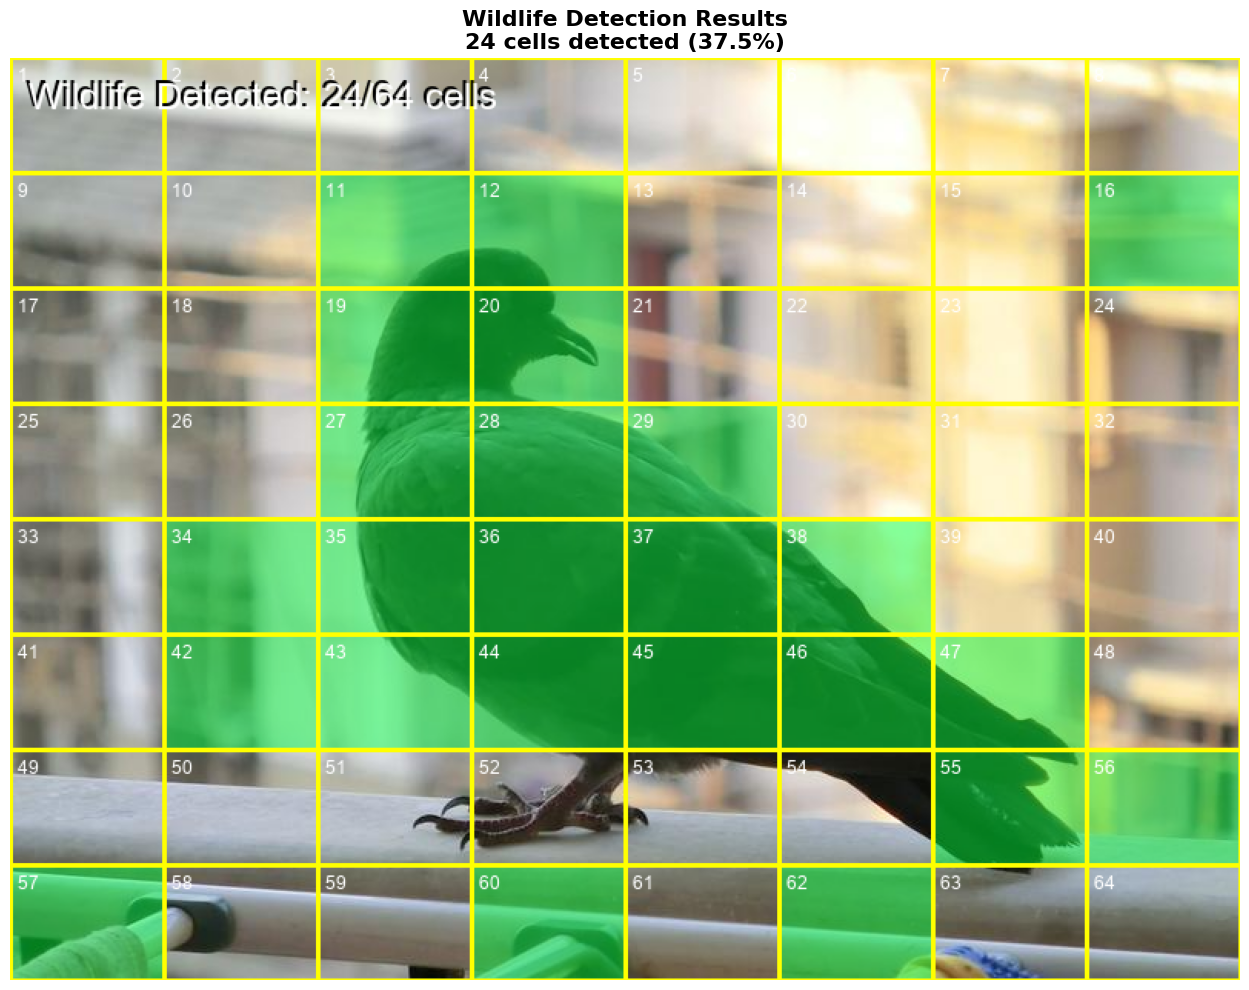


✅ DETECTION COMPLETE!

📊 Final Results:
  Wildlife cells: 24/64


In [4]:
"""
Wildlife Detection - Test New Images (With Saved Scaler & Selector)
Loads all preprocessing objects and makes predictions

Usage:
    python test_with_preprocessing.py path/to/image.jpg
"""

import os
import pickle
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from skimage import color, filters
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# ============================================================================

MODEL_PATH = "training_output/trained_model.pkl"
SCALER_PATH = "training_output/scaler.pkl"
SELECTOR_PATH = "training_output/selector.pkl"

# ============================================================================
# FEATURE EXTRACTION (SAME AS TRAINING)
# ============================================================================

def preprocess_image(image_path, target_size=(800, 600)):
    """Preprocess image to 4:3 aspect ratio and 800x600"""
    img = Image.open(image_path)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    width, height = img.size
    aspect_ratio = width / height
    target_aspect = 4/3

    if abs(aspect_ratio - target_aspect) > 0.05:
        if aspect_ratio > target_aspect:
            new_width = int(height * target_aspect)
            left = (width - new_width) // 2
            img = img.crop((left, 0, left + new_width, height))
        else:
            new_height = int(width / target_aspect)
            top = (height - new_height) // 2
            img = img.crop((0, top, width, top + new_height))

    width, height = img.size
    if width > target_size[0] or height > target_size[1]:
        img = img.resize(target_size, Image.LANCZOS)

    return img

def extract_color_histogram(cell_rgb, bins=16):
    features = []
    for channel in range(3):
        hist, _ = np.histogram(cell_rgb[:,:,channel], bins=bins, range=(0, 256))
        hist = hist / (hist.sum() + 1e-7)
        features.extend(hist)

    cell_hsv = color.rgb2hsv(cell_rgb / 255.0)
    for channel in range(3):
        hist, _ = np.histogram(cell_hsv[:,:,channel], bins=bins, range=(0, 1))
        hist = hist / (hist.sum() + 1e-7)
        features.extend(hist)

    return features

def extract_color_moments(cell_rgb):
    features = []
    for channel in range(3):
        ch_data = cell_rgb[:,:,channel].flatten()
        features.extend([np.mean(ch_data), np.std(ch_data), skew(ch_data)])

    cell_hsv = color.rgb2hsv(cell_rgb / 255.0)
    for channel in range(3):
        ch_data = cell_hsv[:,:,channel].flatten()
        features.extend([np.mean(ch_data), np.std(ch_data), skew(ch_data)])

    return features

def extract_glcm_features(cell_gray):
    cell_gray = (cell_gray * 255).astype(np.uint8)
    try:
        glcm = graycomatrix(cell_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=256, symmetric=True, normed=True)
        features = []
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
            values = graycoprops(glcm, prop)
            features.extend([np.mean(values), np.std(values)])
        return features
    except:
        return [0] * 10

def extract_lbp_features(cell_gray, radius=1, n_points=8):
    cell_gray = (cell_gray * 255).astype(np.uint8)
    lbp = local_binary_pattern(cell_gray, n_points, radius, method='uniform')
    n_bins = n_points * (n_points - 1) + 3
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist / (hist.sum() + 1e-7)
    return hist.tolist()

def extract_edge_features(cell_gray):
    edges_x = filters.sobel_h(cell_gray)
    edges_y = filters.sobel_v(cell_gray)
    edges = np.sqrt(edges_x**2 + edges_y**2)

    features = [np.mean(edges), np.std(edges), np.max(edges), np.sum(edges > 0.1) / edges.size]
    angles = np.arctan2(edges_y, edges_x)
    hist, _ = np.histogram(angles, bins=8, range=(-np.pi, np.pi))
    hist = hist / (hist.sum() + 1e-7)
    features.extend(hist)
    return features

def extract_hog_features(cell_gray):
    try:
        if cell_gray.shape[0] < 8 or cell_gray.shape[1] < 8:
            return [0] * 36
        fd = hog(cell_gray, orientations=9, pixels_per_cell=(4, 4),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        return fd.tolist()
    except:
        return [0] * 36

def extract_statistical_features(cell_gray):
    data = cell_gray.flatten()
    return [np.mean(data), np.std(data), np.var(data), skew(data), kurtosis(data),
            np.min(data), np.max(data), np.median(data), 
            np.percentile(data, 25), np.percentile(data, 75)]

def extract_all_features_from_cell(cell_rgb, cell_gray):
    features = []
    features.extend(extract_color_histogram(cell_rgb, bins=16))
    features.extend(extract_color_moments(cell_rgb))
    features.extend(extract_glcm_features(cell_gray))
    features.extend(extract_lbp_features(cell_gray))
    features.extend(extract_edge_features(cell_gray))
    features.extend(extract_hog_features(cell_gray))
    features.extend(extract_statistical_features(cell_gray))
    return features

def process_image_to_grid(image_path, grid_size=8):
    """Process image and extract features for all 64 cells"""
    img = preprocess_image(image_path)
    img_array = np.array(img)
    img_gray = color.rgb2gray(img_array)

    height, width = img_array.shape[:2]
    cell_height = height // grid_size
    cell_width = width // grid_size

    all_cell_features = []

    for i in range(grid_size):
        for j in range(grid_size):
            y_start = i * cell_height
            y_end = (i + 1) * cell_height
            x_start = j * cell_width
            x_end = (j + 1) * cell_width

            cell_rgb = img_array[y_start:y_end, x_start:x_end]
            cell_gray = img_gray[y_start:y_end, x_start:x_end]

            cell_features = extract_all_features_from_cell(cell_rgb, cell_gray)
            all_cell_features.append(cell_features)

    return all_cell_features, img

# ============================================================================
# PREDICTION & VISUALIZATION
# ============================================================================

def predict_wildlife(image_path, model, selector, scaler):
    """
    Predict wildlife with proper preprocessing

    Returns:
        predictions: 64-element array (0 or 1 for each cell)
        img: preprocessed PIL image
    """
    print(f"  Processing: {os.path.basename(image_path)}")

    # Extract features
    features, img = process_image_to_grid(image_path)
    features = np.array(features)

    print(f"    Raw features: {features.shape}")

    # Handle NaN
    features = np.nan_to_num(features, nan=0.0)

    # ⭐ APPLY SELECTOR (remove low-variance features)
    features = selector.transform(features)
    print(f"    Features after selector: {features.shape}")

    # ⭐ APPLY SCALER (standardize)
    features = scaler.transform(features)
    print(f"    Features after scaler: {features.shape}")

    # Predict
    predictions = model.predict(features)

    return predictions, img

def visualize_predictions(img, predictions, grid_size=8, save_path=None):
    """
    Draw grid overlay with highlighted wildlife cells

    Green cells = Wildlife detected
    Yellow grid = Cell boundaries
    """
    img_with_grid = img.copy()
    draw = ImageDraw.Draw(img_with_grid, 'RGBA')

    width, height = img.size
    cell_width = width // grid_size
    cell_height = height // grid_size

    wildlife_count = np.sum(predictions)

    # Draw grid and highlight wildlife cells
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            x_start = j * cell_width
            y_start = i * cell_height
            x_end = x_start + cell_width
            y_end = y_start + cell_height

            # Highlight wildlife cells in GREEN
            if predictions[idx] == 1:
                draw.rectangle([x_start, y_start, x_end, y_end],
                             fill=(0, 255, 60, 120))

            # Draw grid lines (yellow border)
            draw.rectangle([x_start, y_start, x_end, y_end],
                         outline=(255, 255, 0, 255), width=2)

            # Add cell number
            try:
                font = ImageFont.truetype("arial.ttf", 12)
            except:
                font = ImageFont.load_default()

            text = str(idx + 1)
            draw.text((x_start + 5, y_start + 5), text, 
                     fill=(255, 255, 255, 255), font=font)

    # Add summary text
    try:
        font_large = ImageFont.truetype("arial.ttf", 24)
    except:
        font_large = ImageFont.load_default()

    text = f"Wildlife Detected: {wildlife_count}/64 cells"
    draw.text((10, 10), text, fill=(0, 0, 0, 255), font=font_large)
    draw.text((12, 12), text, fill=(255, 255, 255, 255), font=font_large)

    # Display
    plt.figure(figsize=(14, 10))
    plt.imshow(img_with_grid)
    plt.title(f"Wildlife Detection Results\n{wildlife_count} cells detected ({wildlife_count/64*100:.1f}%)", 
             fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  ✓ Saved: {save_path}")

    plt.show()

    return img_with_grid

def print_cell_map(predictions, grid_size=8):
    """Print ASCII map of predictions"""
    print("\n  Cell-by-Cell Detection Map:")
    print("  🟢 = Wildlife | ⚪ = Background\n")

    for i in range(grid_size):
        row = f"  Row {i+1}: "
        for j in range(grid_size):
            idx = i * grid_size + j
            if predictions[idx] == 1:
                row += "🟢 "
            else:
                row += "⚪ "
        print(row)

    print()

# ============================================================================
# MAIN TESTING FUNCTION
# ============================================================================

def test_image(image_path, model_path=MODEL_PATH, 
               scaler_path=SCALER_PATH, selector_path=SELECTOR_PATH,
               save_result=True):
    """
    Complete pipeline: load model + preprocessing, predict, visualize
    """
    print("="*70)
    print("🔍 WILDLIFE DETECTION - TEST NEW IMAGE")
    print("="*70)

    if not os.path.exists(image_path):
        print(f"\n❌ Error: Image not found: {image_path}")
        return None, None

    # ⭐ Load model, scaler, selector
    print("\n[1/3] Loading model and preprocessing objects...")

    try:
        # Try loading from dict first
        with open(model_path, 'rb') as f:
            saved_obj = pickle.load(f)

        if isinstance(saved_obj, dict):
            model = saved_obj['model']
            scaler = saved_obj['scaler']
            selector = saved_obj['selector']
            print("  ✓ Loaded from combined file: model + scaler + selector")
        else:
            model = saved_obj
            # Load separate scaler and selector
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            with open(selector_path, 'rb') as f:
                selector = pickle.load(f)
            print("  ✓ Model loaded")
            print("  ✓ Scaler loaded")
            print("  ✓ Selector loaded")
    except Exception as e:
        print(f"  ❌ Error loading: {e}")
        return None, None

    # Predict
    print("\n[2/3] Predicting wildlife locations...")
    try:
        predictions, img = predict_wildlife(image_path, model, selector, scaler)
    except Exception as e:
        print(f"  ❌ Prediction failed: {e}")
        return None, None

    wildlife_count = np.sum(predictions)
    background_count = 64 - wildlife_count

    print(f"  ✓ Detected wildlife in {wildlife_count}/64 cells ({wildlife_count/64*100:.1f}%)")
    print(f"    Wildlife cells: {wildlife_count}")
    print(f"    Background cells: {background_count}")

    # Print cell map
    print_cell_map(predictions)

    # Visualize
    print("[3/3] Generating visualization...")
    save_path = None
    if save_result:
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        save_path = f"{base_name}_wildlife_detected.png"

    try:
        visualize_predictions(img, predictions, save_path=save_path)
    except Exception as e:
        print(f"  ⚠ Visualization error: {e}")

    print("\n" + "="*70)
    print("✅ DETECTION COMPLETE!")
    print("="*70)

    return predictions, img

# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    import sys

    print("""
    ╔══════════════════════════════════════════════════════════════╗
    ║  Wildlife Detection - Test Script (With Preprocessing)       ║
    ║  Loads: Model + Scaler + Selector                            ║
    ╚══════════════════════════════════════════════════════════════╝
    """)

    # if len(sys.argv) > 1:
    #     image_path = sys.argv[1]
    # else:
    #     image_path = input("Enter path to test image: ").strip()
    image_path = r"CIMG0005.jpg"

    predictions, img = test_image(
        image_path=image_path,
        model_path=MODEL_PATH,
        scaler_path=SCALER_PATH,
        selector_path=SELECTOR_PATH,
        save_result=True
    )

    if predictions is not None:
        print(f"\n📊 Final Results:")
        print(f"  Wildlife cells: {np.sum(predictions)}/64")
      


    ╔══════════════════════════════════════════════════════════════╗
    ║  Wildlife Detection - Test Script (With Preprocessing)       ║
    ║  Loads: Model + Scaler + Selector                            ║
    ╚══════════════════════════════════════════════════════════════╝
    
🔍 WILDLIFE DETECTION - TEST NEW IMAGE

[1/3] Loading model and preprocessing objects...
  ✓ Loaded from combined file: model + scaler + selector

[2/3] Predicting wildlife locations...
  Processing: CIMG0119.jpg
    Raw features: (64, 4255)
    Features after selector: (64, 4192)
    Features after scaler: (64, 4192)
  ✓ Detected wildlife in 22/64 cells (34.4%)
    Wildlife cells: 22
    Background cells: 42

  Cell-by-Cell Detection Map:
  🟢 = Wildlife | ⚪ = Background

  Row 1: ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 
  Row 2: ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ ⚪ 
  Row 3: ⚪ ⚪ ⚪ 🟢 🟢 🟢 🟢 ⚪ 
  Row 4: ⚪ ⚪ ⚪ 🟢 🟢 🟢 🟢 ⚪ 
  Row 5: ⚪ ⚪ ⚪ 🟢 🟢 🟢 🟢 ⚪ 
  Row 6: ⚪ ⚪ ⚪ ⚪ 🟢 🟢 🟢 🟢 
  Row 7: ⚪ ⚪ ⚪ ⚪ ⚪ 🟢 🟢 🟢 
  Row 8: ⚪ ⚪ ⚪ ⚪ 🟢 🟢 🟢 ⚪ 

[3/3] Generating visualization...

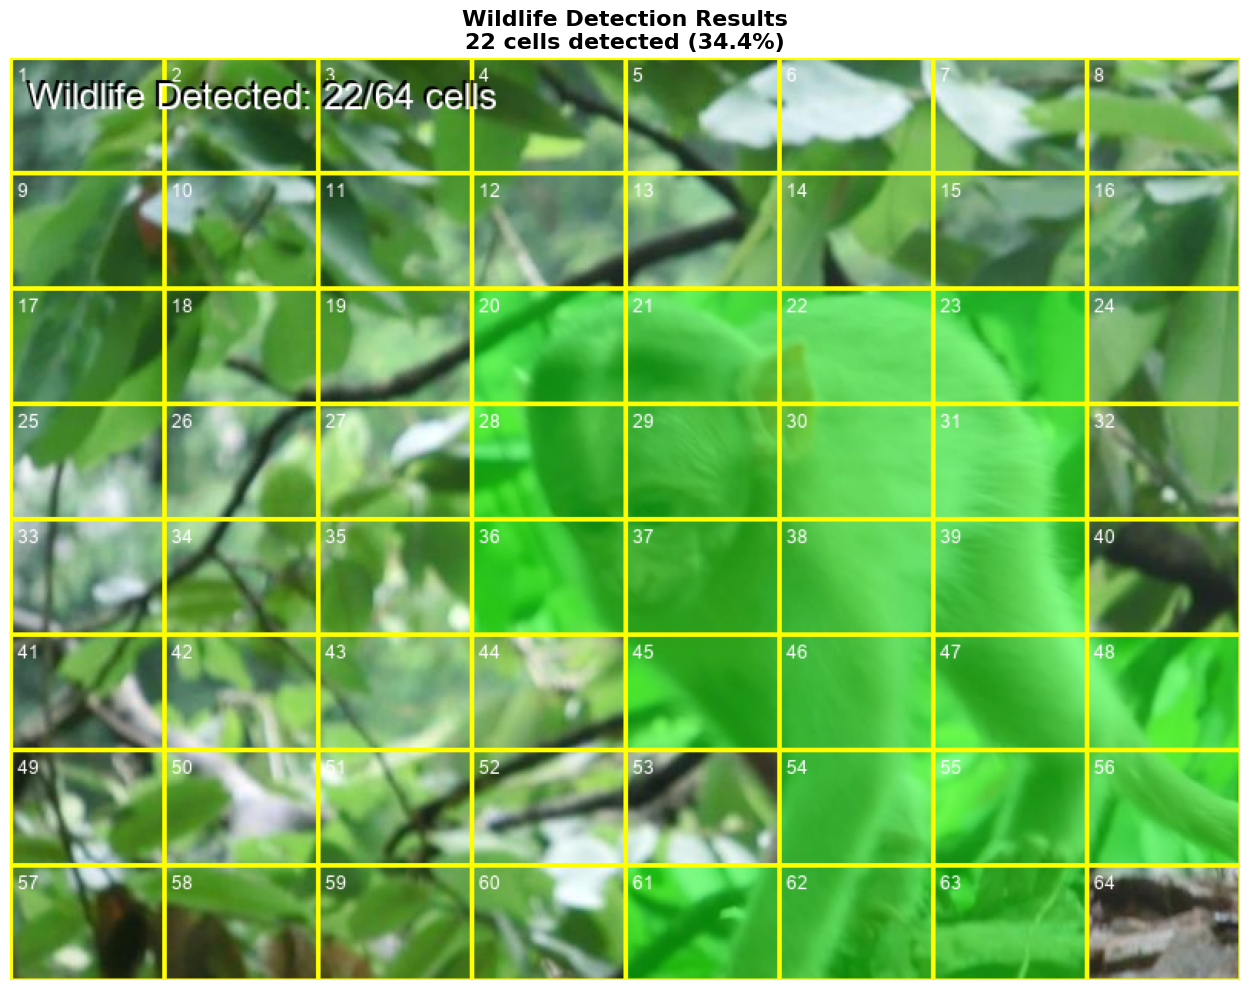


✅ DETECTION COMPLETE!

📊 Final Results:
  Wildlife cells: 22/64
  Background cells: 42/64
  Detection rate: 34.4%


In [ ]:
  print(f"  Background cells: {64-np.sum(predictions)}/64")
        print(f"  Detection rate: {np.sum(predictions)/64*100:.1f}%")